# Pb scavenging parameterization

BLING ends in April, 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
import modules.mapping_functions as mf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Parameters / settings:

In [2]:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

In [3]:
colors = ['#f6c6bb', '#fa654a', '#e9bb65', '#78add6']

color = ['#00cc99', '#138484', '#0099ff', '#0d55ad', '#b6cce6', '#cc99cc', '#9966cc', '#5b3d7a', '#cdc4d7']

#### Load files

In [4]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [5]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'

dset = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/BLING-EPM101/ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons = dset['nav_lon'].values
ANHA4_lats = dset['nav_lat'].values
ANHA4_depths = dset['deptht'].values

# dset_bio = xr.open_dataset(f'{folder_EPM101}ANHA4-EPM101_climatology.nc')
# biomass concentration in phosphate units [mol P/m3]
# biomass  = dset_bio['biomass_p'][:,0,:,:,:].mean(axis=0).values # calculate mean over the 12 months
# biomass  = dset_bio['biomass_p'][0,:,:,:].values

In [6]:
# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202210/oMn_y2002m01.nc')
# based on same j dimensions, but longer i dimensions
ANHA12_lons     = mesh_lon[imin:imax,jmin:jmax]
ANHA12_lats     = mesh_lat[imin:imax,jmin:jmax]
ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values # OR calculate mean over the 12 months
# ANHA12_Mn   = dset_ANHA12['dissolmn'][6,0,:,40:,:].values # calculate mean over the 12 months

#### Functions:

In [11]:
# composition recipe:
def estimate_residence_time(beta, constant):
    
    particles = (1-beta)*normalized_biogenic + beta*normalized_lithogenic
    particles[particles <= 0] = np.nan
    particles[particles < 5e-5] = 5e-5 # no smaller
    
    modelled_res_time = 1 / (constant*particles)
    modelled_res_time[mesh_bathy[:,imin:imax,jmin:jmax] < 0.1] = np.nan ### uses old dimension coordinates
    
    return modelled_res_time/(3600*24*365)

### Particle estimates:

In [12]:
ANHA12_biomass = np.empty((50,isize,jsize))
for depth in range(0,50):
    ANHA12_biomass[depth,:,:] = mf.interp_np_zero(ANHA4_lons.flatten(), ANHA4_lats.flatten(), \
                                                  biomass[depth,:,:].flatten(), ANHA12_lons, ANHA12_lats)
    
ANHA12_biomass[ANHA12_biomass < 0] = 0

NameError: name 'ANHA4_lons' is not defined

In [15]:
# particles:
normalized_biogenic   = ANHA12_biomass/np.amax(ANHA12_biomass)
normalized_lithogenic = ANHA12_Mn/np.amax(ANHA12_Mn)

particle composition recipe: 
- $\beta$ --- lithogenic fraction
- $1-\beta$ --- biogenic fraction

Mean simulated biomass during period of sampling is normalized (biogenic particles) and combined with normalized Mn model field (lithogenic particles) as a measure of particle abundance. Then the particle abundance is inversely related to the residence time. Free parameters are: constant of inverse proportionality, fraction biogenic vs. lithogenic.

In [16]:
betas     = np.linspace(0,1,20)
constants = np.linspace(0.7e-5,2e-5,20)
kadko_res_time_diff     = np.empty((len(kadko_res),len(constants),len(betas))); kadko_res_time_diff[:]     = np.nan;
kadko_modelled_res_time = np.empty((len(kadko_res),len(constants),len(betas))); kadko_modelled_res_time[:] = np.nan;
chen_res_time_diff      = np.empty((len(chen_res),len(constants),len(betas)));  chen_res_time_diff[:]      = np.nan;
chen_modelled_res_time  = np.empty((len(chen_res),len(constants),len(betas)));  chen_modelled_res_time[:]  = np.nan;

for ci,c in enumerate(constants):
    for bi, beta in enumerate(betas):
        # Pb residence time estimate associated with these fractions
        res_time_yrs = estimate_residence_time(beta, c)
        
        # Difference be tween modeled and observed residence time at the stations:
        # Kadko et al., 2019
        for n, stn in enumerate(zip(kadko_ANHA12_i, kadko_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                kadko_modelled_res_time[n,ci,bi] = np.mean(res_time_yrs[0:18,stni,stnj],axis=0)                # mean over upper 50 m
                kadko_res_time_diff[n,ci,bi]     = kadko_res[n] - np.mean(res_time_yrs[0:18,stni,stnj],axis=0) # mean over upper 50 m
        # Chen et al., 2012
        for n, stn in enumerate(zip(chen_ANHA12_i, chen_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                chen_modelled_res_time[n,ci,bi] = np.mean(res_time_yrs[0:18,stni,stnj],axis=0)               # mean over upper 50 m
                chen_res_time_diff[n,ci,bi]     = chen_res[n] - np.mean(res_time_yrs[0:18,stni,stnj],axis=0) # mean over upper 50 m
                
# Calculate mean difference and RMS between model residence time and observed residence time:
kadko_res_time_diff_mean = np.nanmean(kadko_res_time_diff, axis=0)
chen_res_time_diff_mean  = np.nanmean(chen_res_time_diff, axis=0)
kadko_res_time_rms       = np.sqrt(np.nansum(kadko_res_time_diff**2, axis=0)/np.count_nonzero(~np.isnan(kadko_res_time_diff)))
chen_res_time_rms        = np.sqrt(np.nansum(chen_res_time_diff**2, axis=0)/np.count_nonzero(~np.isnan(chen_res_time_diff)))

In [17]:
cif, bif = np.meshgrid(constants, betas)

#### Figures

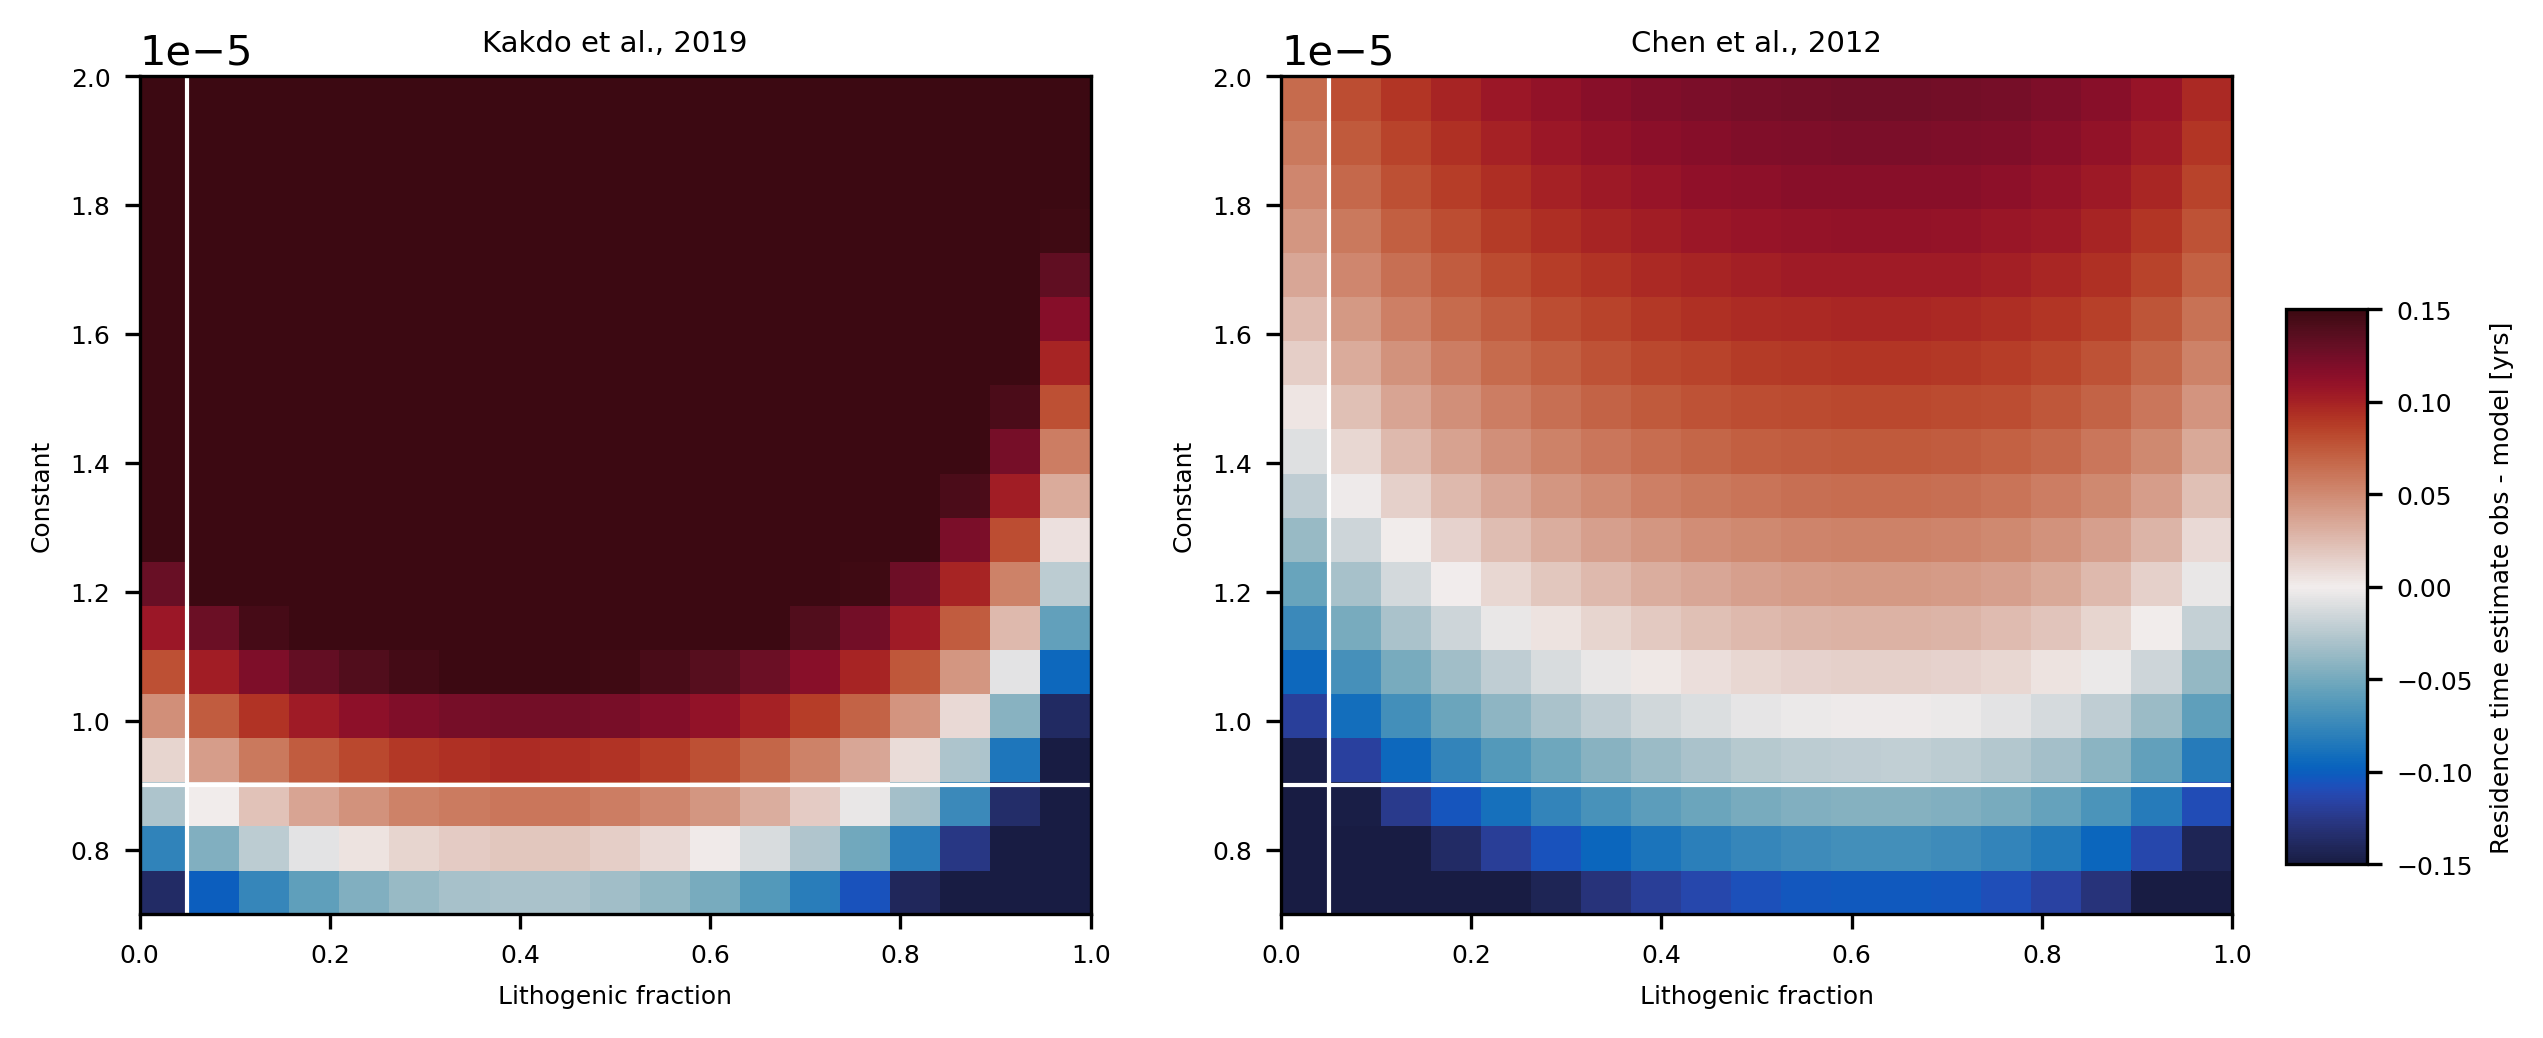

In [41]:
fig, ax = plt.subplots(1,2, figsize=(4.5*2,3.7), dpi=300)

CB1 = ax[0].pcolormesh(bif, cif, kadko_res_time_diff_mean.transpose(), cmap = cmocean.cm.balance, vmin=-0.15, vmax=0.15)
CB2 = ax[1].pcolormesh(bif, cif, chen_res_time_diff_mean.transpose() , cmap = cmocean.cm.balance, vmin=-0.15, vmax=0.15)

ax[0].set_title('Kakdo et al., 2019', fontsize=7)
ax[1].set_title('Chen et al., 2012' , fontsize=7)

for axis in ax.ravel():
    axis.plot([0, 1],[0.9e-5, 0.9e-5],'-w', linewidth=1.0)
    axis.plot([0.05, 0.05],[0.7e-5,2e-5],'-w', linewidth=1.0)
    axis.set_xlabel('Lithogenic fraction', fontsize=6)
    axis.set_ylabel('Constant', fontsize=6)
    axis.set_xlim(0,1)
#     axis.set_ylim(1e-3,8e-3)
    axis.tick_params(labelsize=6) 

# Colorbar:
cbaxes = fig.add_axes([0.92, 0.17, 0.03, 0.50]) 
CBar = plt.colorbar(CB2, ax=ax[1], cax=cbaxes, orientation='vertical')#, ticks=np.arange(-1,1.2,0.2))
CBar.ax.tick_params(labelsize=6) 
CBar.set_label('Residence time estimate obs - model [yrs]', fontsize=6)

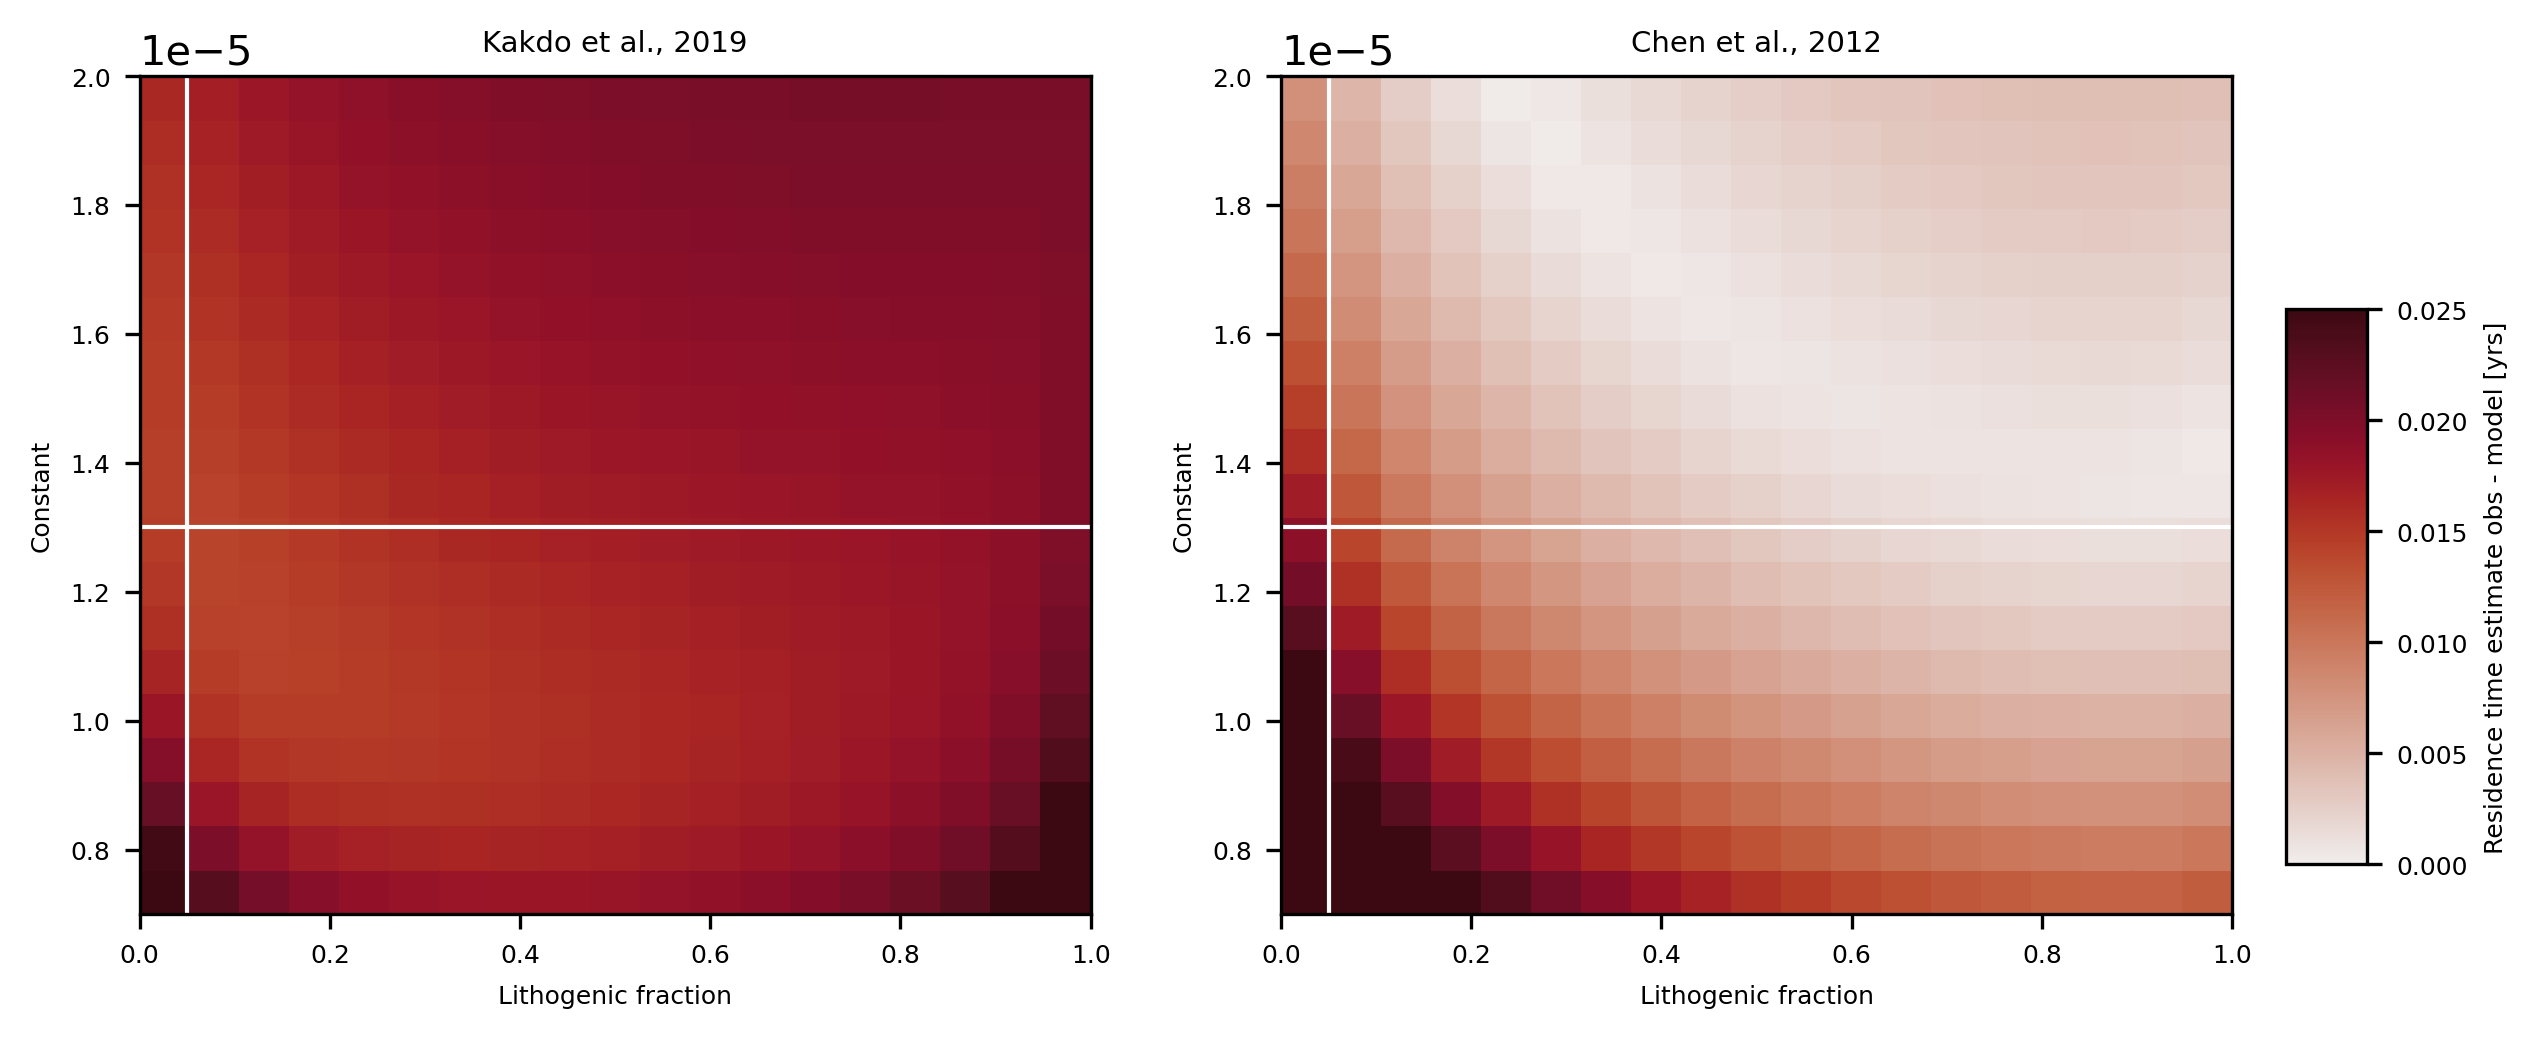

In [19]:
fig, ax = plt.subplots(1,2, figsize=(4.5*2,3.7), dpi=300)

CB1 = ax[0].pcolormesh(bif, cif, kadko_res_time_rms.transpose(), cmap = cmocean.cm.amp, vmin=0.0, vmax=0.025)
CB2 = ax[1].pcolormesh(bif, cif, chen_res_time_rms.transpose() , cmap = cmocean.cm.amp, vmin=0.0, vmax=0.025)

ax[0].set_title('Kakdo et al., 2019', fontsize=7)
ax[1].set_title('Chen et al., 2012' , fontsize=7)

for axis in ax.ravel():
    axis.plot([0, 1],[1.3e-5, 1.3e-5],'-w', linewidth=1.0)
    axis.plot([0.05, 0.05],[0.7e-5,2e-5],'-w', linewidth=1.0)
    axis.set_xlabel('Lithogenic fraction', fontsize=6)
    axis.set_ylabel('Constant', fontsize=6)
    axis.set_xlim(0,1)
#     axis.set_ylim(1e-3,8e-3)
    axis.tick_params(labelsize=6) 

# Colorbar:
cbaxes = fig.add_axes([0.92, 0.17, 0.03, 0.50]) 
CBar = plt.colorbar(CB2, ax=ax[1], cax=cbaxes, orientation='vertical')#, ticks=np.arange(-1,1.2,0.2))
CBar.ax.tick_params(labelsize=6) 
CBar.set_label('Residence time estimate obs - model [yrs]', fontsize=6)

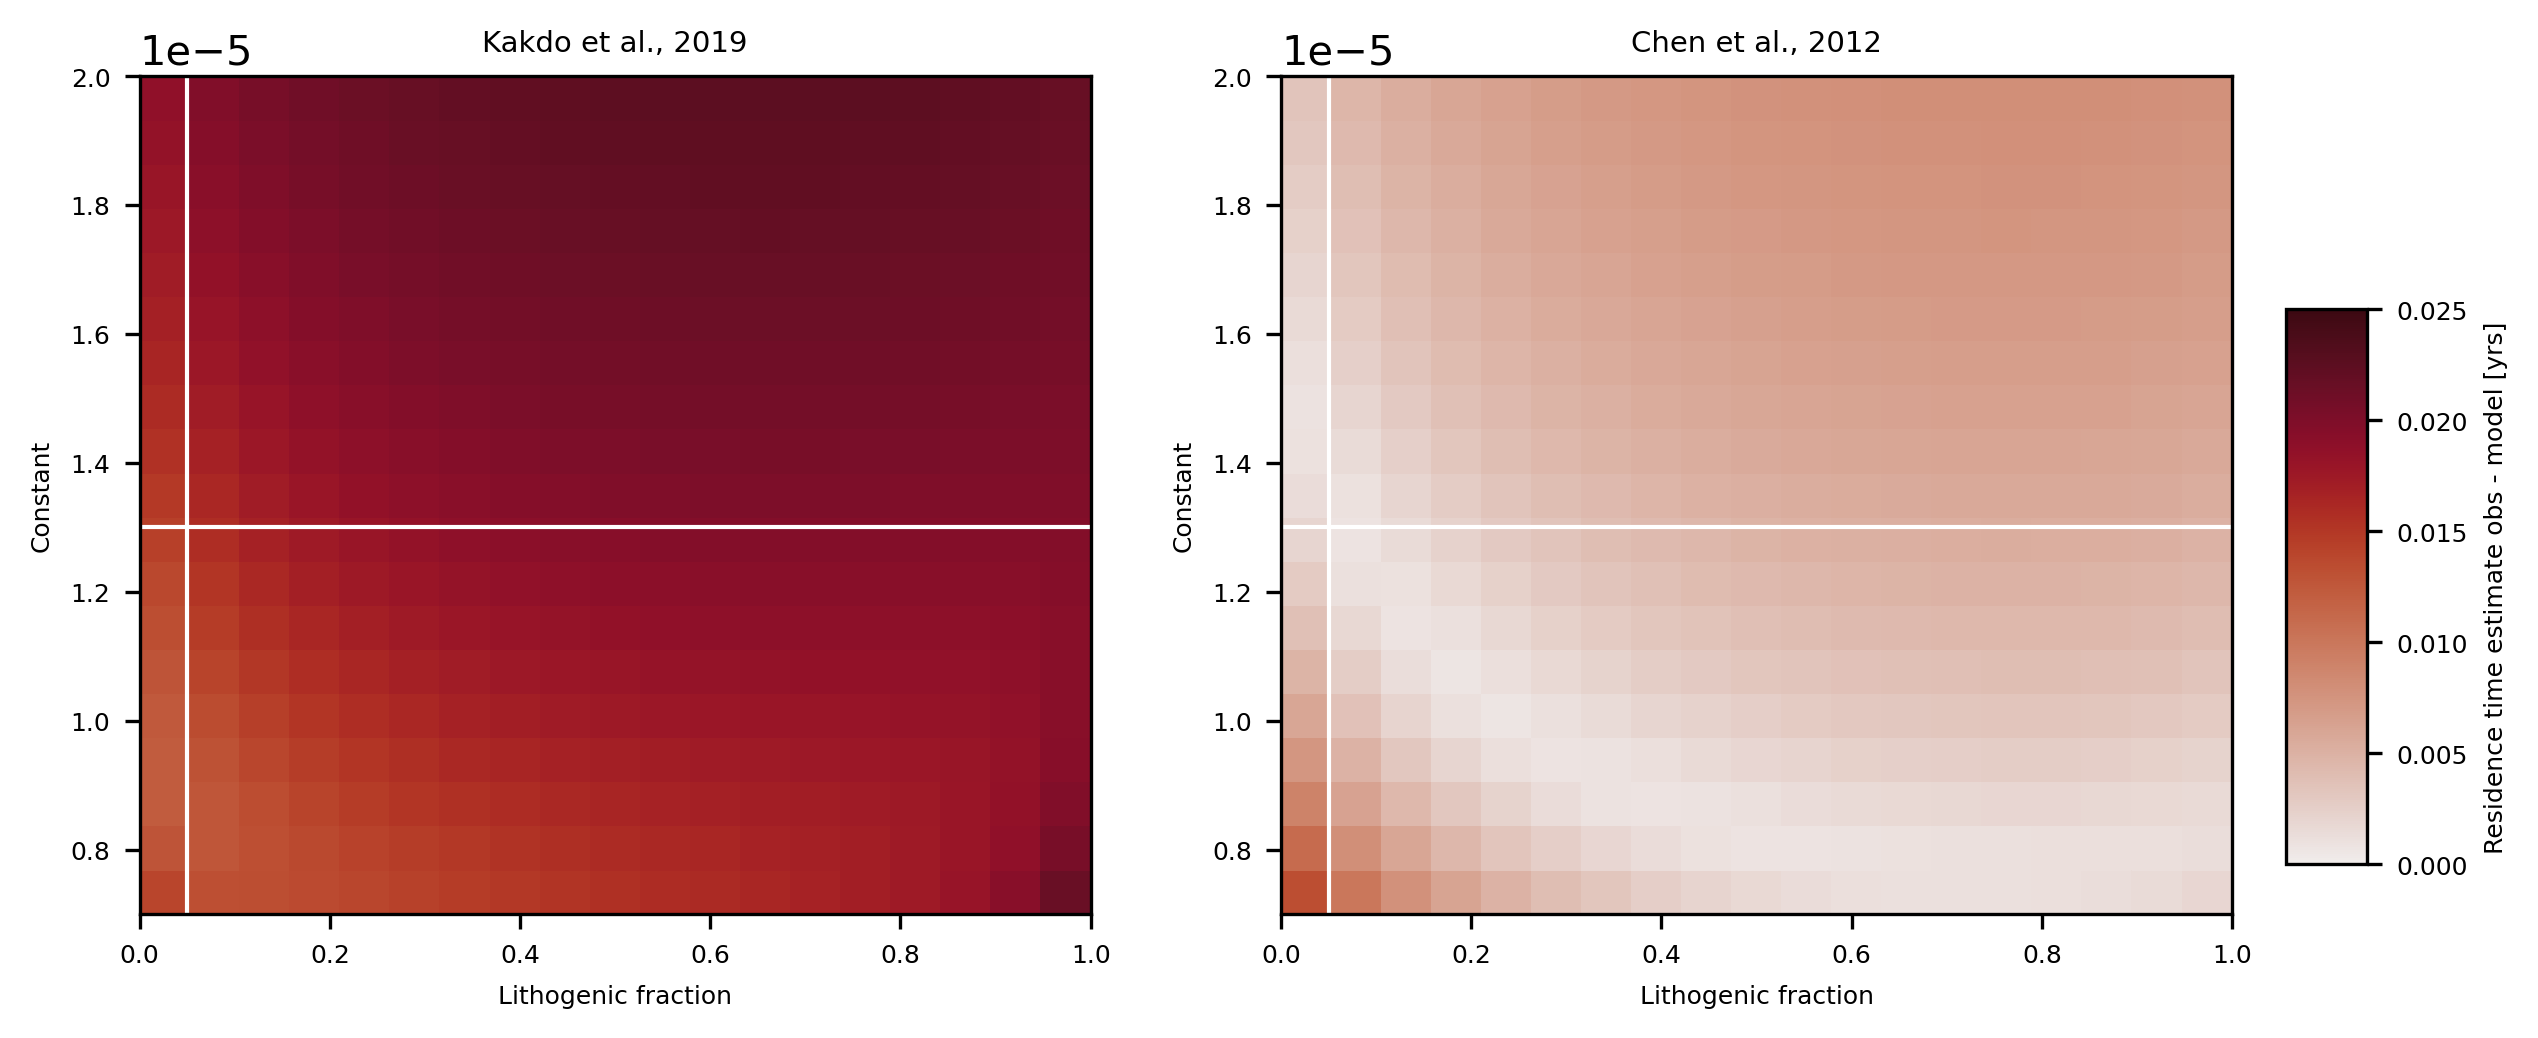

In [30]:
fig, ax = plt.subplots(1,2, figsize=(4.5*2,3.7), dpi=300)

CB1 = ax[0].pcolormesh(bif, cif, kadko_res_time_rms.transpose(), cmap = cmocean.cm.amp, vmin=0.0, vmax=0.025)
CB2 = ax[1].pcolormesh(bif, cif, chen_res_time_rms.transpose() , cmap = cmocean.cm.amp, vmin=0.0, vmax=0.025)

ax[0].set_title('Kakdo et al., 2019', fontsize=7)
ax[1].set_title('Chen et al., 2012' , fontsize=7)

for axis in ax.ravel():
    axis.plot([0, 1],[1.3e-5, 1.3e-5],'-w', linewidth=1.0)
    axis.plot([0.05, 0.05],[0.7e-5,2e-5],'-w', linewidth=1.0)
    axis.set_xlabel('Lithogenic fraction', fontsize=6)
    axis.set_ylabel('Constant', fontsize=6)
    axis.set_xlim(0,1)
#     axis.set_ylim(1e-3,8e-3)
    axis.tick_params(labelsize=6) 

# Colorbar:
cbaxes = fig.add_axes([0.92, 0.17, 0.03, 0.50]) 
CBar = plt.colorbar(CB2, ax=ax[1], cax=cbaxes, orientation='vertical')#, ticks=np.arange(-1,1.2,0.2))
CBar.ax.tick_params(labelsize=6) 
CBar.set_label('Residence time estimate obs - model [yrs]', fontsize=6)

#### Create files:

In [14]:
def find_max_bio(year, month):
    # BLING:
    file_EPM101 = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
    dset_bio    = xr.open_dataset(f'{file_EPM101}')
    biomass     = dset_bio['biomass_p'][:,:,:].values
    
    max_bio = np.nanmax(biomass[mask_ANHA4_full==0])
    
    # interpolate from ANHA4 to ANHA12 grid:
#     ANHA12_biomass = np.empty((50,isize,jsize))
#     for depth in range(0,50):
#         ANHA12_biomass[depth,:,:] = mf.interp_np_zero(ANHA4_lons.flatten(), ANHA4_lats.flatten(), \
#                                                       biomass[depth,:,:].flatten(), ANHA12_lons, ANHA12_lats)

#     ANHA12_biomass[ANHA12_biomass < 0] = 0
    
    return max_bio

def find_max_litho(year, month):
    # Mn for surface particle field:
    folder_Mn   = f'/data/brogalla/run_storage/Mn-extended-domain-202210/'
    dset_ANHA12 = xr.open_dataset(f'{folder_Mn}oMn_y{year}m{month:02}.nc')
    ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values 
    
    max_litho = np.amax(ANHA12_Mn)
    
    return max_litho

In [101]:
n=0
max_bio_list   = np.empty((12*19)); max_bio_list[:]   = np.nan;
for year in range(2002, 2021/):
    print(year)
    for month in range(1,13):
        try:
            max_bio = find_max_bio(year, month)
        except:
            max_bio = np.nan
            
        max_bio_list[n]   = max_bio
        
        n+=1

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [104]:
np.nanmax(max_bio_list)

0.0007667616009712219

In [73]:
n=0
max_litho_list = np.empty((12*19)); max_litho_list[:] = np.nan;
for year in range(2002, 2021):
    print(year)
    for month in range(1,13): 
        try:
            max_litho = find_max_litho(year, month)
        except:
            max_litho = np.nan
            
        max_litho_list[n] = max_litho
        
        n+=1

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [15]:
np.argmax(max_litho_list)

1.8331377305003116e-07

In [12]:
def save_file(folder, litho_array, bio_array, year, month):    
    file_write = xr.Dataset(
        {'lithogenic' : (("deptht","y","x"), litho_array),
         'biogenic' : (("deptht","y","x"), bio_array)}, 
        coords = {
            "time_counter": np.zeros(1),
            "deptht": depths,
            "y": np.zeros(mesh_lat.shape[0]),
            "x": np.zeros(mesh_lon.shape[1])},
    )
    file_write.to_netcdf(f'{folder}Pb_scavenging_y{year}m{month:02}.nc', \
                         unlimited_dims='time_counter')
    
    return

In [13]:
def load_bio(year, month):
    # BLING:
    file_EPM101 = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
    dset_bio    = xr.open_dataset(f'{file_EPM101}')
    biomass     = dset_bio['biomass_p'][:,:,:].values
    
    # interpolate from ANHA4 to ANHA12 grid:
    ANHA12_biomass = np.empty((50,isize,jsize))
    for depth in range(0,50):
        ANHA12_biomass[depth,:,:] = mf.interp_np_zero(ANHA4_lons.flatten(), ANHA4_lats.flatten(), \
                                                      biomass[depth,:,:].flatten(), ANHA12_lons, ANHA12_lats)

    ANHA12_biomass[ANHA12_biomass < 0] = 0
    
    return ANHA12_biomass

def load_litho(year, month):
    # Mn for surface particle field:
    folder_Mn   = f'/data/brogalla/run_storage/Mn-extended-domain-202210/'
    dset_ANHA12 = xr.open_dataset(f'{folder_Mn}oMn_y{year}m{month:02}.nc')
    ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values 
    
    return ANHA12_Mn

In [17]:
def create_particle_fields(year, month, save=False, beta=np.nan):
    ANHA12_biomass = load_bio(year, month)
    ANHA12_litho   = load_litho(year, month)

    # particles: normalize by maximum value within domain over the course of the full time series
    normalized_biogenic   = ANHA12_biomass/0.0007668 # np.amax(ANHA12_biomass)
    normalized_lithogenic = ANHA12_litho/1.83314e-07  # np.amax(ANHA12_litho)

    lithogenic_particles = np.ones(mesh_bathy.shape)*0.01
    biogenic_particles   = np.ones(mesh_bathy.shape)*0.01
    lithogenic_particles[:,imin:imax,jmin:jmax] = normalized_lithogenic
    biogenic_particles[:,imin:imax,jmin:jmax]   = normalized_biogenic
    
    if save:
        if np.isnan(beta):
            print('need to define beta')
        else:
            folder ='/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/'
            betas  = [0.03,0.05,0.07] #,0.15,0.25] #[0.00, 0.01, 0.02]
#             save_file(f'{folder}particle6-2/', lithogenic_particles*betas[0], biogenic_particles*(1-betas[0]), year, month)
#             save_file(f'{folder}particle7-2/', lithogenic_particles*betas[1], biogenic_particles*(1-betas[1]), year, month)
#             save_file(f'{folder}particle8-2/', lithogenic_particles*betas[2], biogenic_particles*(1-betas[2]), year, month)
#             save_file(f'{folder}particle1-2/', lithogenic_particles*betas[0], biogenic_particles*(1-betas[0]), year, month)
#             save_file(f'{folder}particle2-2/', lithogenic_particles*betas[1], biogenic_particles*(1-betas[1]), year, month)
#             save_file(f'{folder}particle3-2/', lithogenic_particles*betas[2], biogenic_particles*(1-betas[2]), year, month)
            
            betas = [0.95, 0.98, 0.99]
            save_file(f'{folder}particle9-2/', lithogenic_particles*betas[0], biogenic_particles*(1-betas[0]), year, month)
            save_file(f'{folder}particle10-2/', lithogenic_particles*betas[1], biogenic_particles*(1-betas[1]), year, month)
            save_file(f'{folder}particle11-2/', lithogenic_particles*betas[1], biogenic_particles*(1-betas[1]), year, month)
    
    return lithogenic_particles, biogenic_particles

In [18]:
for month in range(1,13):
    print(month)
    litho, bio = create_particle_fields(2015, month, save=True, beta=0.00)

1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [15]:
for month in range(12,13):
    print(month)
    litho, bio = create_particle_fields(2014, month, save=True, beta=0.00)

12


In [16]:
for month in range(1,2):
    print(month)
    litho, bio = create_particle_fields(2016, month, save=True, beta=0.00)

1
